## SVM

### Aprendizagem Automática e Ciências de Dados
#### Grupo 4
##### Dinis Carraça Nº14058 & José Feiteira Nº14300


In [1]:
%reset -f

## Requirements


In [2]:
!pip install -r requirements.txt
!pip install --upgrade statsmodels
!pip install miceforest
!pip install pingouin
!pip install --upgrade pingouin

  Using cached statsmodels-0.14.4-cp313-cp313-win_amd64.whl.metadata (9.5 kB)
Using cached statsmodels-0.14.4-cp313-cp313-win_amd64.whl (9.8 MB)
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.14.6
    Uninstalling statsmodels-0.14.6:
      Successfully uninstalled statsmodels-0.14.6
  Using cached statsmodels-0.14.6-cp313-cp313-win_amd64.whl.metadata (9.8 kB)
Using cached statsmodels-0.14.6-cp313-cp313-win_amd64.whl (9.5 MB)
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.14.4
    Uninstalling statsmodels-0.14.4:
      Successfully uninstalled statsmodels-0.14.4


### Imports


In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import miceforest as mf
import pingouin as pg

from scipy.spatial import distance
from sklearn.covariance import MinCovDet
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet, EmpiricalCovariance
from scipy.stats import chi2
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler

from miceforest import ImputationKernel

import sklearn.linear_model as skl_lm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.discrete_model import Logit

from scipy.stats import skew



### Data Reading 

In [4]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# Load data
df = pd.read_csv('df_group4_classe.csv')
print(df.head())
print(df.info())
X = df.drop('classe', axis=1)
y = df['classe']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define pipeline and grid
pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
param_grid = {
    'svc__C': [0.1, 1, 10], 
    'svc__gamma': ['scale', 0.01, 0.001], 
    'svc__kernel': ['rbf', 'linear']
}

# Run Grid Search
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Output results
print('Melhor score CV:', grid.best_score_)
print('Melhor params:', grid.best_params_)

# Test score
best_model = grid.best_estimator_
test_score = best_model.score(X_test, y_test)
print('Test score:', test_score)

   daily_active_users_per_1k  avg_session_duration  screens_per_session  \
0                   1.365073              0.767327             0.261780   
1                   0.014407             -0.053756            -0.834279   
2                  -0.794565             -1.364828            -0.794455   
3                  -0.025550             -0.712952            -0.362806   
4                  -0.008756              0.934050             1.951810   

   conversion_rate  retention_30d  crash_rate_per_1k  avg_latency_ms  \
0         0.676673      -0.618089           1.463434        1.076442   
1         0.398714      -0.686036           0.679254       -0.292061   
2        -1.274230       0.337830          -0.048939       -0.509421   
3        -0.316390      -1.306883          -0.596438       -0.276956   
4         0.211716       0.407337          -0.115187       -0.569544   

   support_tickets_per_1k_users  bug_fix_time_days  \
0                      0.883539          -0.825774   
1       

### 1. Preparação dos Dados
Antes de treinar o modelo, o código é necessário preparar os dados para garantir que o computador consegue aprender corretamente.
 - 1.1. Divisão X e y:
    X (Features): Os dados que o modelo usa para analisar (todas as colunas menos a 'classe').
    y (Target): A resposta correta que queremos prever (a coluna 'classe').

- 1.2. Divisão Treino/Teste:
    70% dos dados para ensinar o modelo e guarda 30% para ver se ele aprendeu bem.

Nota: O parâmetro stratify=y garante que se tivermos 50% de Classe A e 50% de Classe B no original, mantemos essa proporção nas divisões.

- 1.3. *Scaling* (StandardScaler):
    Coloca todos os números na mesma escala (média 0 e desvio padrão 1).
    Como o SVM calcula distâncias matemáticas, se uma coluna tiver valores de 0 a 1 e outra de 0 a 1000, o modelo vai achar que a segunda é mais importante apenas porque os números são maiores. O *scaling* corrige isto.

### 2. Os Modelos
O script compara duas versões do SVM para ver qual funciona melhor: 
- SVM Linear (kernel='linear'): Tenta separar as classes usando linhas retas, mais simples e rápido, mas pode falhar se os dados forem complexos.

- VM RBF (kernel='rbf'): Usa curvas complexas para separar as classes, consegue adaptar-se a padrões mais difíceis ("Non-linear").

O código usa um ciclo for para treinar ambos os modelos automaticamente, um a seguir ao outro.

### 3. Avaliação
Após o treino, o código avalia a performance:
- Matriz de Confusão (confusion_matrix): Mostra quantas vezes o modelo acertou e onde se confundiu, ex: previu Classe A, mas era Classe B. 
- Cálculo da Especificidade (Specificity):O sklearn não dá a especificidade diretamente no relatório padrão, por isso o script calcula-a manualmente usando a fórmula: $TN / (TN + FP)$.Mede a capacidade do modelo de não dar falsos alarmes.
- Visualização (Heatmap): Desenha a matriz de confusão com cores para facilitar a leitura.


### 4. A Visualização Avançada (PCA)
Esta é a parte final e mais complexa do script.

Como os dados têm 14 colunas (dimensões) é impossível desenhar um gráfico 14D num ecrã 2D.

A Solução PCA:

- 4.1. Redução: O PCA "esmaga" as 14 dimensões em apenas 2 dimensões principais, tentando perder o mínimo de informação possível.

- 4.2. Volta a treinar para Visualização: O script treina novos SVMs apenas nestas 2 dimensões.

- 4.3. Gráfico de Fronteiras (contourf):

    - 4.3.1. Pinta o fundo do gráfico com cores diferentes.

    - 4.3.2. As cores mostram as "zonas de decisão" do modelo. Se um ponto cair na zona amarela, o modelo classifica-o como a classe amarela.

    - 4.3.4. Isto permite ver se o modelo está a desenhar uma linha reta (Linear) ou uma forma curva/orgânica (RBF) para separar os pontos.

--- A carregar dataset ---

--- A treinar modelos SVM ---

=== Resultados: SVM Linear ===
              precision    recall  f1-score   support

           1       0.40      0.33      0.36        12
           2       0.62      0.57      0.59        14
           3       0.61      0.74      0.67        19
           4       0.71      0.62      0.67         8
           5       0.79      0.79      0.79        24

    accuracy                           0.65        77
   macro avg       0.63      0.61      0.62        77
weighted avg       0.65      0.65      0.64        77

Specificity (Macro Average): 0.9100


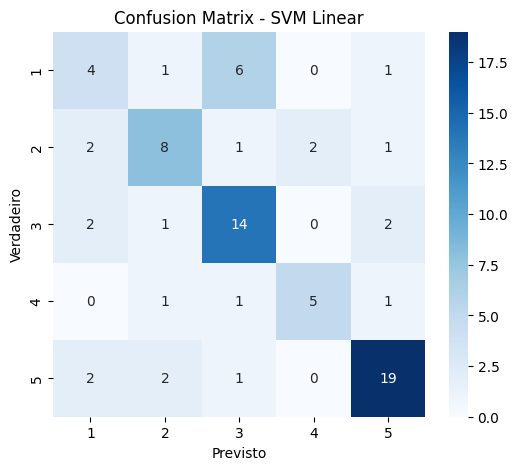


=== Resultados: SVM RBF ===
              precision    recall  f1-score   support

           1       0.62      0.42      0.50        12
           2       0.79      0.79      0.79        14
           3       0.67      0.74      0.70        19
           4       0.67      0.50      0.57         8
           5       0.82      0.96      0.88        24

    accuracy                           0.74        77
   macro avg       0.71      0.68      0.69        77
weighted avg       0.73      0.74      0.73        77

Specificity (Macro Average): 0.9324


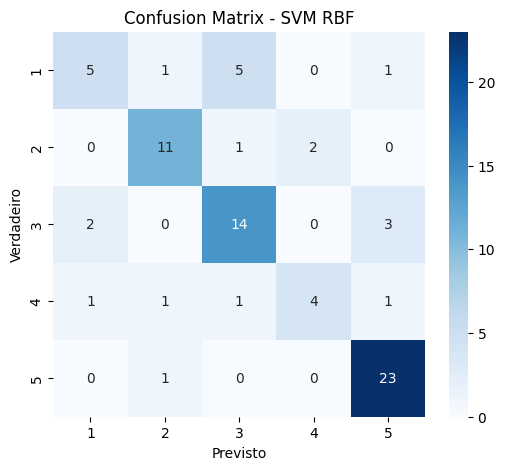


--- A gerar visualização 2D (PCA) ---


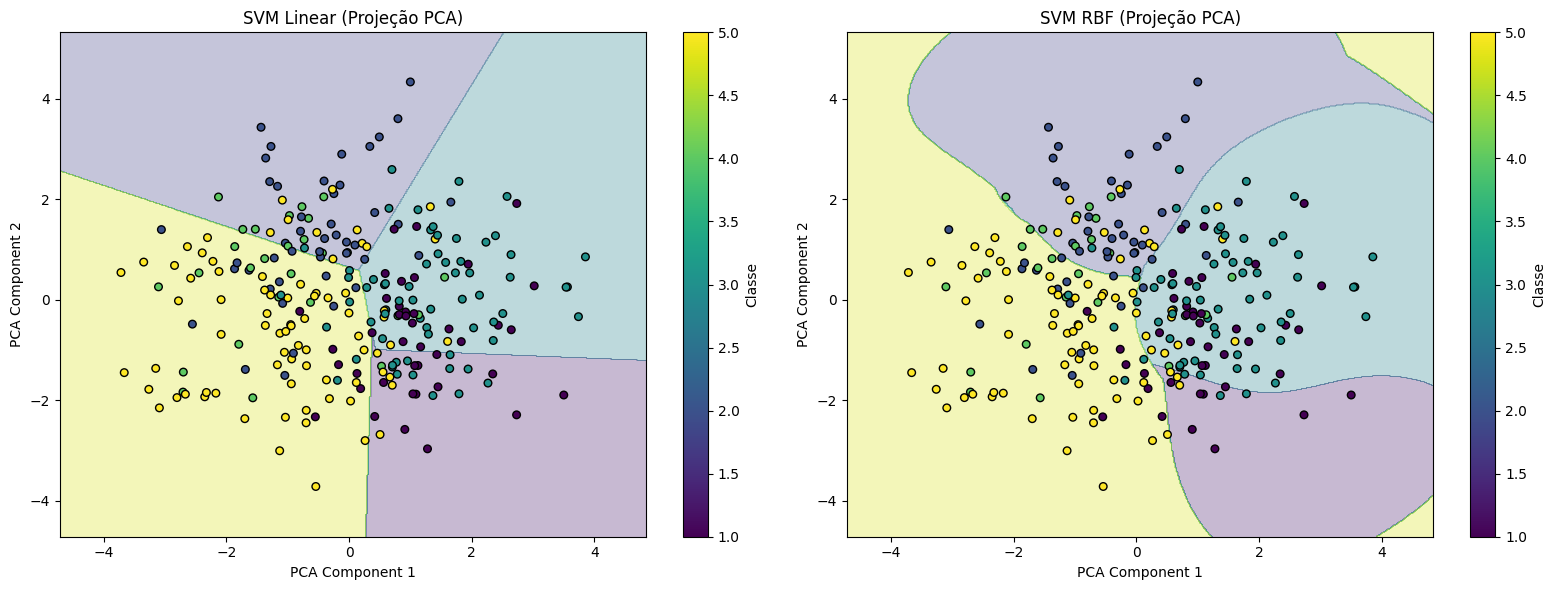

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA

# ==========================================
# 1. Carregamento e Preparação dos Dados
# ==========================================
print("--- A carregar dataset ---")
# Carregar o dataset
df = pd.read_csv('df_group4_classe.csv')

# Separar Features (X) e Target (y)
X = df.drop('classe', axis=1)  # Todas as colunas exceto 'classe'
y = df['classe']               # A coluna alvo

# Dividir em Treino (70%) e Teste (30%)
# 'stratify=y' garante que a proporção das classes se mantém igual no treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Escalamento dos dados (CRÍTICO para SVM)
# O SVM calcula distâncias, por isso features com escalas grandes dominariam o modelo
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================================
# 2. Definição e Treino dos Modelos
# ==========================================
print("\n--- A treinar modelos SVM ---")

models = {
    "SVM Linear": SVC(kernel='linear', C=1),
    "SVM RBF": SVC(kernel='rbf', gamma='scale', C=1)
}

# Dicionário para guardar as previsões para uso posterior
predictions = {}

for name, model in models.items():
    # Treinar
    model.fit(X_train_scaled, y_train)
    
    # Prever
    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred
    
    # --- Avaliação ---
    print(f"\n=== Resultados: {name} ===")
    
    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    
    # Cálculo da Especificidade para Multiclasse (Média Macro)
    # Specificity = TN / (TN + FP) calculado para cada classe contra as outras
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    
    specificity_per_class = TN / (TN + FP)
    macro_specificity = np.mean(specificity_per_class)
    
    # Print Métricas
    print(classification_report(y_test, y_pred))
    print(f"Specificity (Macro Average): {macro_specificity:.4f}")
    
    # Plot da Matriz de Confusão
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.show()

# ==========================================
# 3. Visualização com PCA (Projeção 2D)
# ==========================================
print("\n--- A gerar visualização 2D (PCA) ---")
# Nota: Como temos 14 features, não podemos desenhar o gráfico diretamente.
# Usamos PCA para reduzir a 2 dimensões principais para visualizar as fronteiras.

# Reduzir todo o dataset para 2 dimensões
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaler.transform(X)) # Usar dados escalados

# Criar modelos SVM simplificados apenas para esta visualização 2D
# (Isto é uma aproximação para podermos ver o gráfico)
models_viz = [
    SVC(kernel='linear', C=1),
    SVC(kernel='rbf', gamma='scale', C=1)
]
titles = ["SVM Linear (Projeção PCA)", "SVM RBF (Projeção PCA)"]

plt.figure(figsize=(16, 6))

for i, clf in enumerate(models_viz):
    # Treinar na projeção 2D
    clf.fit(X_pca, y)
    
    plt.subplot(1, 2, i + 1)
    
    # Criar grid para desenhar fronteiras
    h = .02  # tamanho do passo na malha
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Prever para cada ponto da grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot das fronteiras e contornos
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    
    # Plot dos pontos de dados
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolors='k', s=30)
    plt.title(titles[i])
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter, label='Classe')

plt.tight_layout()
plt.show()


Existem duas formas principais de interpretar isto, e o script abaixo implementa ambas para ser o mais completo possível:
   1. Visualização de Clusters (t-SNE): Substituí o PCA pelo t-SNE (t-Distributed Stochastic Neighbor Embedding). O t-SNE é muito superior ao PCA para visualização, pois consegue agrupar visualmente dados semelhantes, formando "ilhas" ou clusters visíveis no gráfico 2D.
   
   2. Algoritmo de Clustering (K-Means): Adicionei também o algoritmo K-Means para agrupar os dados em 5 clusters (já que temos 5 classes) e comparar se o agrupamento automático coincide com as classes reais.


### 1. Preparação dos Dados (Igual ao anterior)
O início é padrão:
- Separa as perguntas (X) das respostas (y).
- Escalamento: Continua a ser crucial colocar tudo na mesma escala numérica, tanto para o SVM como para o K-Means e t-SNE funcionarem bem.

### 2. O SVM
Esta parte é o método clássico:

- Usamos o SVM Linear.
- Damos ao modelo os dados de treino e as respostas corretas (classes).
- Ele aprende e depois testamos a sua nota final. Isto serve de "linha de base" para saberes quão bem é possível distinguir estas classes.


### 3. Análise de Estrutura (t-SNE e K-Means)
Aqui o script muda radicalmente. O objetivo agora é responder a: "Se eu não dissesse ao computador quais são as classes, será que ele conseguia descobrir sozinho que existem 5 grupos diferentes?"

#### A. t-SNE
- Diferença chave: O PCA roda os dados para encontrar a "melhor vista". O t-SNE é mais flexível; ele tenta garantir que pontos que são "vizinhos" nos dados originais (14 dimensões) continuam vizinhos no desenho 2D.

- Resultado: O t-SNE cria "ilhas" ou aglomerados visuais muito mais definidos que o PCA. É excelente para visualizar separação de classes.

#### B. K-Means
- O processo: O algoritmo coloca 5 pontos aleatórios e começa a puxar os dados mais próximos para si, ajustando o centro de cada grupo repetidamente.

- O detalhe: Ele não sabe o que é a "Classe 1" ou "Classe 2". Ele apenas agrupa por semelhança matemática.

### 4. Comparação
O script gera uma imagem com dois gráficos lado a lado para comparares a Realidade vs. Descoberta Automática:

- Interpretação: Se o gráfico da direita for muito parecido com o da esquerda (mesmo que as cores sejam diferentes, ex: o grupo azul na esquerda é o vermelho na direita), significa que as tuas classes são naturalmente distintas.

### 5. Crosstab
No final, o script imprime uma tabela cruzada (pd.crosstab).

- Nas linhas: As Classes Reais.

- Nas colunas: Os Clusters (0, 1, 2, 3, 4).

Exemplo de como ler a tabela: Se na linha da "Classe 1" tiveres 100 pontos no "Cluster 2" e 0 nos outros, é perfeito! Significa que o K-Means descobriu sozinho essa classe inteira. Se os números estiverem espalhados, o computador está confuso.

--- A carregar dataset ---

--- A treinar modelos SVM ---
-> Treinando SVM Linear...
-> Treinando SVM RBF (Non-Linear)...

=== RESULTADOS DA BATALHA ===
Accuracy SVM Linear: 0.6494
Accuracy SVM RBF:    0.7403
>> CONCLUSÃO: Os dados são NÃO-LINEARES (O modelo curvo venceu).

--- Relatório Detalhado (Melhor Modelo) ---
              precision    recall  f1-score   support

           1       0.62      0.42      0.50        12
           2       0.79      0.79      0.79        14
           3       0.67      0.74      0.70        19
           4       0.67      0.50      0.57         8
           5       0.82      0.96      0.88        24

    accuracy                           0.74        77
   macro avg       0.71      0.68      0.69        77
weighted avg       0.73      0.74      0.73        77


--- A gerar Visualização t-SNE e K-Means ---


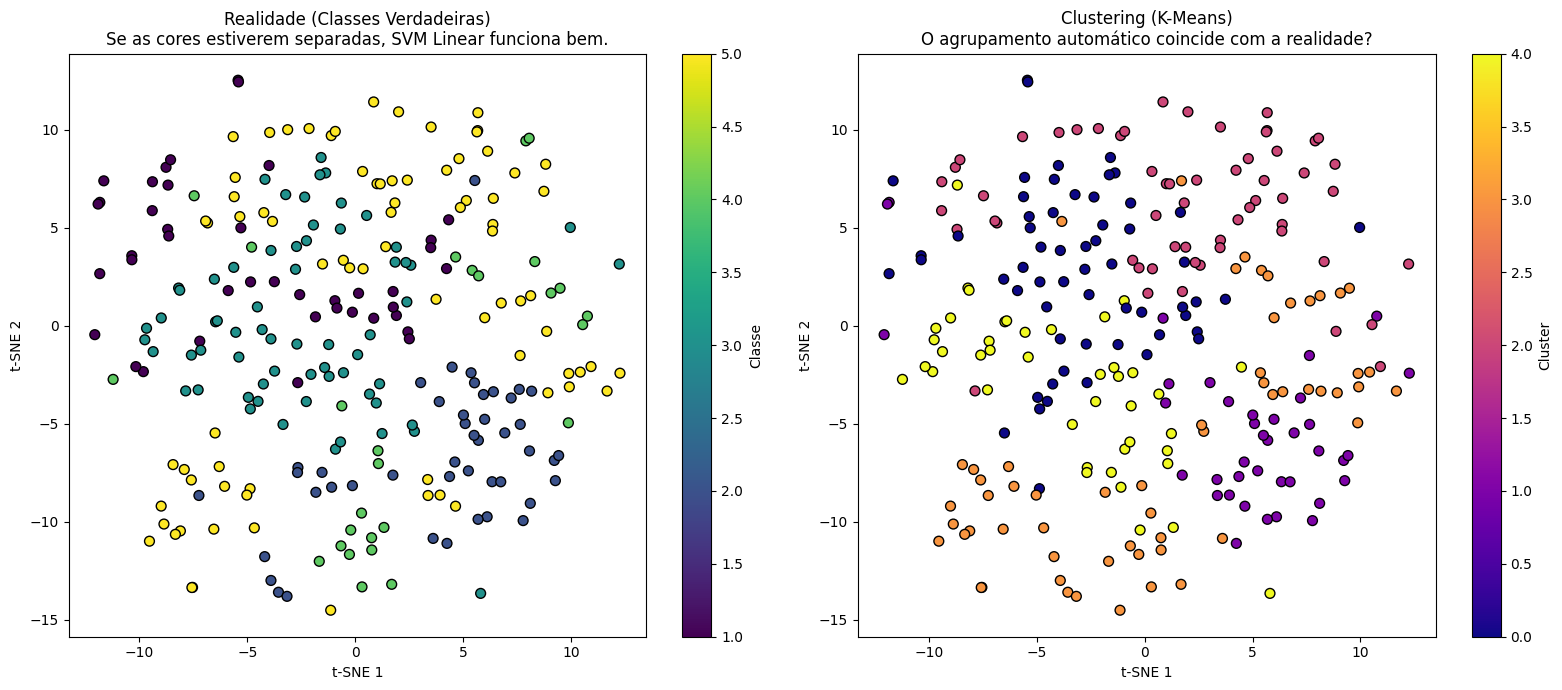


=== Matriz de Comparação: Classes Reais vs Clusters K-Means ===
Cluster K-Means   0   1   2   3   4
Classe Real                        
1                20   4  10   1   6
2                 0  25   1  14   5
3                29   2   6   2  25
4                 1   1   5  14   6
5                 9   6  36  27   0


In [6]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# ==========================================
# 1. Carregamento e Preparação dos Dados
# ==========================================
print("--- A carregar dataset ---")
df = pd.read_csv('df_group4_classe.csv')

X = df.drop('classe', axis=1)
y = df['classe']

# Split (Treino/Teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale (Essencial para SVM e K-Means)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled_full = scaler.transform(X) # Para o t-SNE/K-Means

# ==========================================
# 2. Batalha de SVMs: Linear vs Não-Linear
# ==========================================
print("\n--- A treinar modelos SVM ---")

# A) SVM Linear (A Régua)
print("-> Treinando SVM Linear...")
svm_linear = SVC(kernel='linear', C=1)
svm_linear.fit(X_train_scaled, y_train)
y_pred_linear = svm_linear.predict(X_test_scaled)

# B) SVM RBF (A Curva - Não Linear)
print("-> Treinando SVM RBF (Non-Linear)...")
svm_rbf = SVC(kernel='rbf', C=1, gamma='scale')
svm_rbf.fit(X_train_scaled, y_train)
y_pred_rbf = svm_rbf.predict(X_test_scaled)

# --- Comparação de Resultados ---
acc_linear = accuracy_score(y_test, y_pred_linear)
acc_rbf = accuracy_score(y_test, y_pred_rbf)

print(f"\n=== RESULTADOS DA BATALHA ===")
print(f"Accuracy SVM Linear: {acc_linear:.4f}")
print(f"Accuracy SVM RBF:    {acc_rbf:.4f}")

if acc_rbf > acc_linear + 0.02: # Se RBF for 2% melhor
    print(">> CONCLUSÃO: Os dados são NÃO-LINEARES (O modelo curvo venceu).")
elif acc_linear > acc_rbf:
    print(">> CONCLUSÃO: Os dados são LINEARES (O modelo simples venceu ou RBF overfitting).")
else:
    print(">> CONCLUSÃO: Empate técnico (A complexidade extra do RBF não trouxe ganhos).")

print("\n--- Relatório Detalhado (Melhor Modelo) ---")
# Imprime o relatório do vencedor
if acc_rbf > acc_linear:
    print(classification_report(y_test, y_pred_rbf))
else:
    print(classification_report(y_test, y_pred_linear))

# ==========================================
# 3. Análise de Estrutura (Clustering & t-SNE)
# ==========================================
print("\n--- A gerar Visualização t-SNE e K-Means ---")

# t-SNE para ver a 'forma' dos dados em 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X_scaled_full)

# K-Means para ver como o computador agrupa sozinho
n_classes = len(np.unique(y))
kmeans = KMeans(n_clusters=n_classes, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled_full)

# --- Plotting ---
plt.figure(figsize=(16, 7))

# Plot 1: Realidade (Labels Verdadeiros)
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', edgecolors='k', s=50)
plt.title(f'Realidade (Classes Verdadeiras)\nSe as cores estiverem separadas, SVM Linear funciona bem.')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(scatter1, label='Classe')

# Plot 2: O que o K-Means vê (Sem ajuda)
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=kmeans_labels, cmap='plasma', edgecolors='k', s=50)
plt.title(f'Clustering (K-Means)\nO agrupamento automático coincide com a realidade?')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(scatter2, label='Cluster')

plt.tight_layout()
plt.show()

# Crosstab Final
print("\n=== Matriz de Comparação: Classes Reais vs Clusters K-Means ===")
df_compare = pd.DataFrame({'Classe Real': y, 'Cluster K-Means': kmeans_labels})
print(pd.crosstab(df_compare['Classe Real'], df_compare['Cluster K-Means']))

A conclusão principal que tiramos ao correr este script é sobre a qualidade dos dados. 

As conclusões que retiramos são:
- A relação entre o SVM e o K-Means diz-nos se as classes são matematicamente distintas ou se são apenas convenções humanas.
Se o K-Means agrupar igual às Classes Reais, os dados são excelentes, as classes estão tão bem definidas nas 14 features que o computador consegue distingui-las mesmo sem saber o que são.

Logo SVM vai ter uma precisão altíssima e será muito robusto.

- Se o K-Means misturar tudo, mas o SVM for bom, as classes existem e são separáveis, mas não formam "ilhas" óbvias. As fronteiras são subtis. O SVM consegue encontrar a linha porque tem as respostas, mas o K-Means perde-se porque os grupos estão encostados ou têm formatos estranhos, não redondos.

- SVM Linear procura Hiperplanos para dividir o espaço, o K-Means procura centróides para agrupar pontos.

Se o SVM Linear tiver má performance, mas o t-SNE/K-Means mostrar grupos visuais claros concluimos que o problema não é linear.

Neste caso, a conclusão seria abandonar o kernel linear e usar obrigatoriamente o kernel mão linear no SVM.

- O diagnóstico de erros e a visualização t-SNE explica visualmente porquê e onde o SVM erra.
Se no gráfico t-SNE existirem pontos azuis misturados no meio de uma nuvem de pontos vermelhos, podemos concluir que nenhum modelo linear do SVM vai conseguir acertar 100%.

O erro do SVM não é totalmente culpa do modelo, mas sim uma característica intrínseca dos dados, ruído ou sobreposição de classes.

--- A carregar dataset ---

--- A treinar modelos SVM para Comparação ---
-> Accuracy SVM Linear: 0.6494
-> Accuracy SVM RBF:    0.7403
>> DIAGNÓSTICO: Dados Não-Lineares (RBF venceu).

--- A calcular t-SNE (Mapa 2D) ---
--- A calcular K-Means (Agrupamento Automático) ---
--- A gerar gráficos com fronteiras de decisão ---


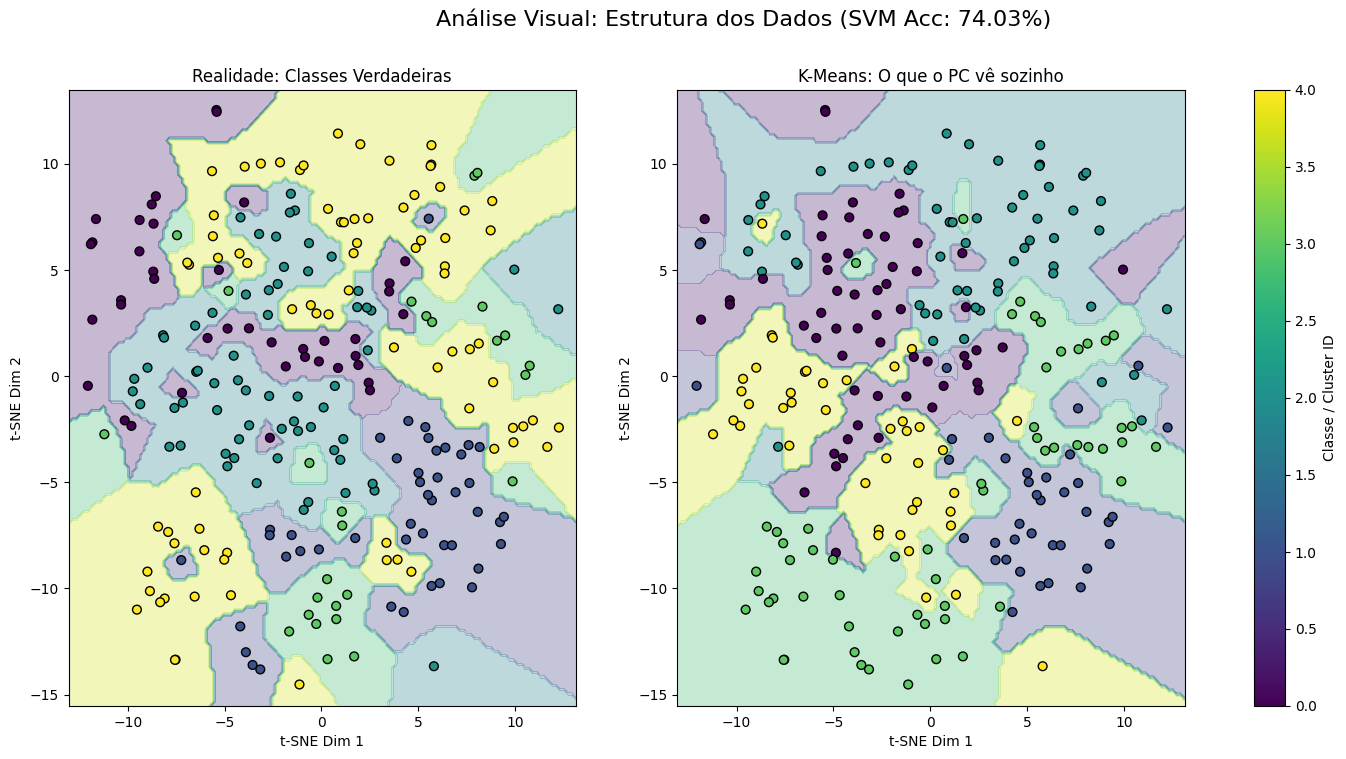


=== Matriz de Comparação (Realidade vs K-Means) ===
Cluster K-Means   0   1   2   3   4
Classe Real                        
1                20   4  10   1   6
2                 0  25   1  14   5
3                29   2   6   2  25
4                 1   1   5  14   6
5                 9   6  36  27   0


In [8]:
from sklearn.neighbors import KNeighborsClassifier

# ==========================================
# 1. Carregamento e Preparação dos Dados
# ==========================================
print("--- A carregar dataset ---")
df = pd.read_csv('df_group4_classe.csv')

X = df.drop('classe', axis=1)
y = df['classe']

# Split para o SVM (Treino/Teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale (Criação de escalas)
scaler = StandardScaler()
# Ajustar scaler aos dados de treino e aplicar
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Aplicar ao dataset completo para a visualização final
X_scaled_full = scaler.transform(X)

# ==========================================
# 2. SVM: Linear vs Não-Linear (Supervisionado)
# ==========================================
print("\n--- A treinar modelos SVM para Comparação ---")

# SVM Linear
svm_linear = SVC(kernel='linear', C=1)
svm_linear.fit(X_train_scaled, y_train)
acc_linear = accuracy_score(y_test, svm_linear.predict(X_test_scaled))

# SVM RBF (Não-Linear)
svm_rbf = SVC(kernel='rbf', C=1, gamma='scale')
svm_rbf.fit(X_train_scaled, y_train)
acc_rbf = accuracy_score(y_test, svm_rbf.predict(X_test_scaled))

print(f"-> Accuracy SVM Linear: {acc_linear:.4f}")
print(f"-> Accuracy SVM RBF:    {acc_rbf:.4f}")

if acc_rbf > acc_linear + 0.02:
    print(">> DIAGNÓSTICO: Dados Não-Lineares (RBF venceu).")
else:
    print(">> DIAGNÓSTICO: Dados Lineares ou Simples (Empate/Linear venceu).")

# ==========================================
# 3. Clustering e Redução de Dimensionalidade
# ==========================================
print("\n--- A calcular t-SNE (Mapa 2D) ---")
# Reduz as 14 dimensões para 2
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X_scaled_full)

print("--- A calcular K-Means (Agrupamento Automático) ---")
# Tenta encontrar grupos sozinho
n_classes = len(np.unique(y))
kmeans = KMeans(n_clusters=n_classes, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled_full)

# ==========================================
# 4. Visualização com Fronteiras (O teu script)
# ==========================================
print("--- A gerar gráficos com fronteiras de decisão ---")

def plot_boundaries(X_2d, labels, title, ax):
    """
    Função auxiliar que usa um KNN simples para 'pintar' o fundo do gráfico
    com base na classe predominante daquela região do t-SNE.
    """
    # 1. Criar a grelha (grid)
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    h = 0.2 # Resolução
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # 2. Treinar "pintor" KNN nas coordenadas 2D
    # Nota: Este KNN é usado APENAS para visualização (pintar o fundo), não é o modelo principal
    knn_viz = KNeighborsClassifier(n_neighbors=1)
    knn_viz.fit(X_2d, labels)
    
    # 3. Prever cor de fundo
    Z = knn_viz.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # 4. Plot
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='viridis') # Fundo
    scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis', edgecolors='k', s=40) # Pontos
    
    ax.set_title(title)
    ax.set_xlabel('t-SNE Dim 1')
    ax.set_ylabel('t-SNE Dim 2')
    return scatter

# Configuração da figura
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot A: Realidade
# Se este gráfico tiver "ilhas" de cor única bem definidas, o SVM (Linear ou RBF) funcionará bem.
plot_boundaries(X_embedded, y, "Realidade: Classes Verdadeiras", ax1)

# Plot B: K-Means
# Mostra como o computador vê os dados "sem óculos" (sem saber as labels).
scatter2 = plot_boundaries(X_embedded, kmeans_labels, "K-Means: O que o PC vê sozinho", ax2)

plt.colorbar(scatter2, ax=[ax1, ax2], label='Classe / Cluster ID')
plt.suptitle(f"Análise Visual: Estrutura dos Dados (SVM Acc: {max(acc_linear, acc_rbf):.2%})", fontsize=16)
plt.show()

# ==========================================
# 5. Tabela de Confirmação
# ==========================================
print("\n=== Matriz de Comparação (Realidade vs K-Means) ===")
df_compare = pd.DataFrame({'Classe Real': y, 'Cluster K-Means': kmeans_labels})
print(pd.crosstab(df_compare['Classe Real'], df_compare['Cluster K-Means']))